In [34]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as sts
import seaborn as sns

In [2]:
#load data
life = os.path.join('DataSets', 'life_expectancy_at_birth.csv')
pop = os.path.join('DataSets', 'population_by_education_level.csv')
eu = os.path.join('DataSets', 'EU_Country_Codes.csv')

life_df = pd.read_csv(life)
life_df = life_df.dropna()

pop_df = pd.read_csv(pop)
pop_df = pop_df.dropna()

eu_df = pd.read_csv(eu,names=['geography','country'], header = None)

In [3]:
life_df['geography'].unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'EU27_2020', 'EU28', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT',
       'LT', 'LU', 'LV', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE', 'SI',
       'SK', 'UK'], dtype=object)

In [4]:
life_df = life_df.drop(life_df[life_df['geography']=='EU27_2020'].index)
life_df = life_df.drop(life_df[life_df['geography']=='EU28'].index)

In [5]:
life_df['sex'].unique()

array(['F', 'M'], dtype=object)

In [6]:
pop_df['geography'].unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EA19', 'EE', 'EL',
       'ES', 'EU27_2020', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT',
       'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS',
       'SE', 'SI', 'SK', 'TR', 'EU15', 'EU28', 'UK'], dtype=object)

In [7]:
pop_df = pop_df.drop(pop_df[pop_df['geography']=='EU27_2020'].index)
pop_df = pop_df.drop(pop_df[pop_df['geography']=='EU28'].index)
pop_df = pop_df.drop(pop_df[pop_df['geography']=='EU15'].index)

In [8]:
pop_df['geography'].unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EA19', 'EE', 'EL',
       'ES', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV',
       'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI',
       'SK', 'TR', 'UK'], dtype=object)

In [9]:
pop_df['sex'].unique()

array(['F', 'M', 'T'], dtype=object)

In [10]:
# drop rows with sex ==T
pop_df = pop_df.drop(pop_df[pop_df['sex']=='T'].index)
pop_df['sex'].unique()

array(['F', 'M'], dtype=object)

In [11]:
# drop rows with geography ==Total
pop_df = pop_df.drop(pop_df[pop_df['isced11']=='TOTAL'].index)

In [12]:
pop_df['date'].unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010,
       2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999,
       1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988,
       1987, 1986, 1985, 1984, 1983])

In [13]:
# merge data frames
life_pop_df = pd.merge(pop_df, life_df, on=['date','geography','sex'], how='inner')
life_pop_eu_df = pd.merge(life_pop_df, eu_df, on='geography', how='left')

In [14]:
life_pop_eu_df = life_pop_eu_df.drop(columns=['unit_x', 'unit_y','statinfo' ])

In [15]:
life_pop_eu_df = life_pop_eu_df.rename(columns={'value_y': 'age_in_year',
                                               'value_x':'population_in_THS',})
life_pop_eu_df.head()

,sex,age,isced11,geography,date,population_in_THS,age_in_year,country
0,F,Y15-19,ED0-2,AT,2019,149.6,84.2,Austria
1,F,Y15-19,ED3_4,AT,2019,52.4,84.2,Austria
2,F,Y15-19,ED5-8,AT,2019,6.9,84.2,Austria
3,F,Y15-24,ED0-2,AT,2019,173.8,84.2,Austria
4,F,Y15-24,ED3_4,AT,2019,196.0,84.2,Austria


In [16]:
life_pop_eu_df['date'].unique()

array([2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009,
       2008])

In [17]:
total_pop_groupby = pd.DataFrame(life_pop_eu_df.groupby(['sex','age', 'geography','date']).sum()['population_in_THS'])
total_pop_groupby = total_pop_groupby.rename(columns={'population_in_THS': 'population_total'})

In [18]:
life_pop_eu_total_df = pd.merge(life_pop_eu_df, total_pop_groupby, on=['sex', 'age','geography','date'],how='inner')

In [19]:
life_pop_eu_total_df['percentage'] = life_pop_eu_total_df['population_in_THS']/life_pop_eu_total_df['population_total']

In [21]:
clean_df = life_pop_eu_total_df

In [23]:
life_df_ana = life_df.reset_index()
life_df_ana.head()

,index,unit,sex,statinfo,geography,date,value
0,0,YR,F,LE_0,AT,2008,83.3
1,1,YR,F,LE_0,BE,2008,82.6
2,2,YR,F,LE_0,BG,2008,77.0
3,3,YR,F,LE_0,CH,2008,84.6
4,4,YR,F,LE_0,CY,2008,82.9


In [57]:
#statistic description of life expectancy
country_lf = life_df_ana.groupby(['sex', 'geography'])['value']
country_lf_stat = country_lf.agg(['mean', 'median','var','std','sem']).sort_values(by=['var'])
country_lf_stat

mean  median       var       std       sem
sex geography                                                 
F   DE         83.191667   83.10  0.097197  0.311764  0.089999
    NL         83.175000   83.20  0.098409  0.313702  0.090558
    AT         83.775000   83.80  0.105682  0.325087  0.093845
    FR         85.550000   85.65  0.137273  0.370503  0.106955
    IS         84.100000   84.10  0.158182  0.397721  0.114812
...                  ...     ...       ...       ...       ...
M   SK         72.833333   73.00  1.155152  1.074780  0.310262
    MT         79.433333   79.70  1.416970  1.190365  0.343629
    LV         69.008333   69.20  1.506288  1.227309  0.354294
    LT         68.891667   68.85  2.731742  1.652798  0.477122
    EE         72.216667   72.60  2.945152  1.716144  0.495408

[62 rows x 5 columns]

In [36]:
# box plot of the life expectancy of Female from 2008-2019
lf_female = life_df_ana[life_df_ana['sex']=='F']

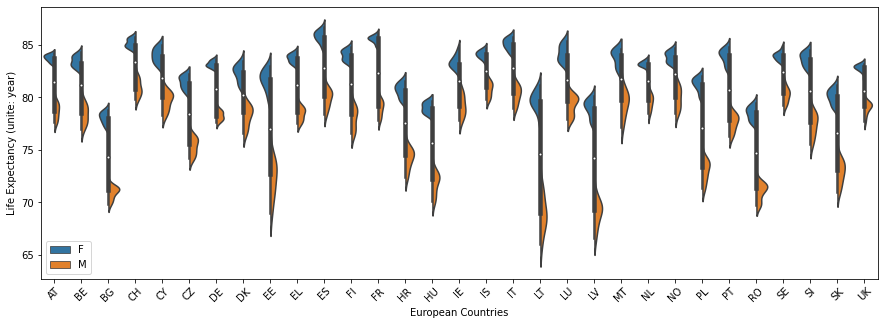

In [67]:
plt.figure(figsize=(15,5))
chart = sns.violinplot(x='geography', y='value', data = life_df_ana, width=0.8, hue='sex', split=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.legend(loc=3)
plt.ylabel('Life Expectancy (unite: year)')
plt.xlabel('European Countries')
plt.show()

In [62]:
# box plot of the life expectancy of Male from 2008-2019
lf_male = life_df_ana[life_df_ana['sex']=='M']

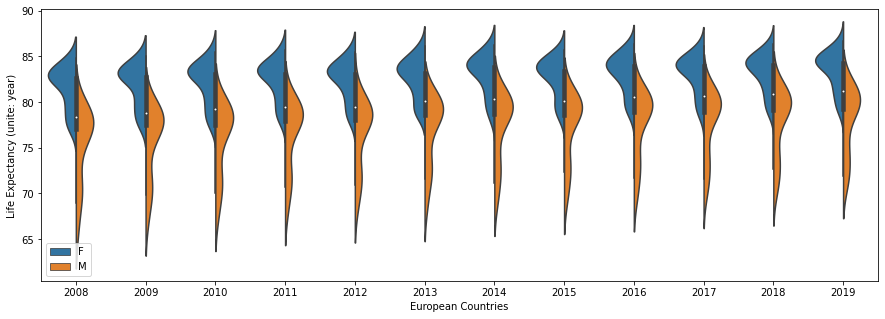

In [68]:
plt.figure(figsize=(15,5))
chart = sns.violinplot(x='date', y='value', data = life_df_ana, width=0.8, hue='sex', split=True)
chart.set_xticklabels(chart.get_xticklabels())
chart.legend(loc=3)
plt.ylabel('Life Expectancy (unite: year)')
plt.xlabel('European Countries')
plt.show()

In [75]:
# yw = os.path.join('DataSets', 'complete_dataset.csv')
# r_merge_df = pd.read_csv(yw)
# r_merge_df.head()